In [1]:
library(httr)
library(jsonlite)
library(utils)
library(glue)

In [2]:
get_authentication_token <- function(client_id, client_secret_id){
    response = POST('https://accounts.spotify.com/api/token',
                    accept_json(),
                    authenticate(client_id, client_secret_id),
                    body = list(grant_type = 'client_credentials'),
                    encode = 'form',
                    verbose())
    authentication_token <<- content(response)$access_token
    return (authentication_token)
}

In [3]:
get_podcast_id <- function(query, market='US'){
    base_url = 'https://api.spotify.com/v1/search'
    response <- GET(base_url, 
                    query = list(q = enc2utf8(query),
                                 type = 'show',
                                 market=market),
                    add_headers(Accept = 'application/json', 
                    Authorization = paste('Bearer', authentication_token)))
    response = content(response)
    return (response$shows$items[[1]]$id)
}

In [13]:
search_for_podcast <- function(keywords, language = 'en', market='US', explicit = TRUE, limit=5){
    base_url = 'https://api.spotify.com/v1/search'
    response <- GET(base_url, 
                    query = list(q = enc2utf8(keywords),
                                 type = 'show',
                                 market=market),
                    add_headers(Accept = 'application/json', 
                    Authorization = paste('Bearer', authentication_token)))
    
    podcast_name = list()
    podcast_publisher = list()
    podcast_id = list()
    explicit_content = list()
    podcast_language = list()
    response = content(response)
    
    search_limit = response$shows$limit

    
    for (i in 1:search_limit){
        podcast_name[[i]] <- response$shows$items[[i]]$name
        podcast_publisher[[i]] <- response$shows$items[[i]]$publisher
        podcast_id[[i]] <- response$shows$items[[i]]$id
        explicit_content[[i]] <- response$shows$items[[i]]$explicit 
        podcast_language[[i]] <- response$shows$items[[i]]$language[[1]]
    }
    
    podcast_search = data.frame(unlist(podcast_name),
                                unlist(podcast_publisher),
                                unlist(explicit_content),
                                unlist(podcast_language),
                                unlist(podcast_id)
                                )
    colnames(podcast_search) <- c('Podcast Name', 'Podcast Publisher', 'Explicit','Language', 'Podcast ID')
    
    if (explicit == FALSE){
        podcast_df <- subset(podcast_search, Explicit == FALSE & Language == language)
        return(head(podcast_df, limit))
    }
    
    else{
        podcast_df <- subset(podcast_search, Language == language)
        return(head(podcast_df, limit))
        }

}

In [25]:
get_recent_episodes <- function(podcast_id, explicit = TRUE, limit=5, market='US', duration=NA){
    base_url = glue('https://api.spotify.com/v1/shows/{podcast_id}/episodes')
    response <- GET(base_url, 
                    query = list(limit=50,
                                 market = market),
                    add_headers(Accept = 'application/json', 
                    Authorization = paste('Bearer', authentication_token)))
    response = content(response)
    
    episode_name = list()
    release_date = list()
    episode_duration = list()
    explicit_content = list()
    episode_id = list()
    
    search_limit = response$limit

    
    for (i in 1:search_limit){
        episode_name[[i]] <- response$item[[i]]$name
        release_date[[i]] <- response$item[[i]]$release_date
        episode_duration[[i]] <- round((response$item[[i]]$duration_ms)/(1000*60),0)
        explicit_content[[i]] <- response$item[[i]]$explicit
        episode_id[[i]] <- response$item[[i]]$id
    }
    
    
    recent_episodes = data.frame(unlist(episode_name),
                                 unlist(release_date),
                                 unlist(episode_duration),
                                 unlist(explicit_content),
                                 unlist(episode_id)
                                )
    colnames(recent_episodes) <- c('Episode Name', 'Release Date', 'Duration','Explicit', 'Episode ID')
    
    
    if (explicit == FALSE){
        recent_episodes_df <- subset(recent_episodes, Explicit == FALSE)
        if (is.na(duration) == FALSE){
            recent_episodes_df <- subset(recent_episodes, Duration <= duration)
            return(recent_episodes_df)
        }
        else{
            return(head(recent_episodes_df, limit))   
        }
            
    }
    
    else{
        if (is.na(duration) == FALSE){
            recent_episodes_df <- subset(recent_episodes, Duration <= duration)
            return(recent_episodes_df)
        }
        else{
            return(head(recent_episodes, limit))   
        }
        }
  
}

In [42]:
get_episode_information <- function(episode_id, market='ES'){
    base_url = glue('https://api.spotify.com/v1/episodes/{episode_id}')
    response <- GET(base_url,
                    query = list(market = market),
                    add_headers(Accept = 'application/json', 
                                Authorization = paste('Bearer', authentication_token)))
    response = content(response)
    
    episode_name = response$name
    episode_description = response$show$description
    episode_information = data.frame(episode_name, episode_description)
    
    return (episode_information)
    
}

### Test

In [44]:
client_id = Sys.getenv('CLIENT_ID')
secret_id = Sys.getenv('CLIENT_SECRET_ID')

authentication_token = get_authentication_token(client_id, secret_id)

In [45]:
episode_id = '5fE0bPigcmwSrrYxjJD4Sv'
episode = get_episode_information(episode_id)
episode

episode_name,episode_description
<chr>,<chr>
Episode #151 ... The Frankfurt School - Erich Fromm on Freedom,"A Free Podcast Dedicated To Sharing The Ideas That Shaped Our World! Beginner friendly if listened to in order! For anyone interested in an educational podcast about philosophy where you don't need to be a graduate-level philosopher to understand it. In chronological order, the thinkers and ideas that forged the world we live in are broken down and explained."


In [9]:
podcast_keywords = 'abroad in japan'
show_id = get_podcast_id(podcast_keywords)
show_id

[1] "1dbguTBIriCwhJXlxTITFe"

In [15]:
podcast_keywords = 'abroad in japan'
response = search_for_podcast(podcast_keywords, limit=10)
response

,Podcast Name,Podcast Publisher,Explicit,Language,Podcast ID
,<chr>,<chr>,<lgl>,<chr>,<chr>
1,Abroad in Japan,Stakhanov,TRUE,en,1dbguTBIriCwhJXlxTITFe
2,Jaded in Japan,Sydney & Sunny,TRUE,en,5RKbdBKUFqL2tUDAwUBS3G
3,So You Want to Work Abroad,Cole Haan,FALSE,en,4ZFAh30UYFW9maJjBlhEnx
4,Living La Vida In Japan,NinjaEddie,FALSE,en,2lWCGxU7EujjEYzIkIELzr
5,Path Beyond - Stories from Abroad,Mucho Arigato,FALSE,en,71eNYRMTEY6bbBQ10pRcSi
7,Tea In Tokyo,"Saumya Bhatta, Ellie King",TRUE,en,2dPIdYYgyTaadJ4uc7mWxO
8,Japan Intercultural Institute,Japan Intercultural Institute,FALSE,en,6lwy7Bje0xREoyxMN1tz3Q
9,Distant Relatives The Podcast,Distant Relatives: Life Abroad in Japan and Australia,FALSE,en,5EITqD7E5wGVAC49AW0jS4
10,Living La Vida In Japan,NinjaEddie,FALSE,en,1dCQSQtSpVxXCscLPIXkP8


In [26]:
response = get_recent_episodes('1dbguTBIriCwhJXlxTITFe',limit=50)

In [37]:
episode$show$description

[1] "A Free Podcast Dedicated To Sharing The Ideas That Shaped Our World!  Beginner friendly if listened to in order! For anyone interested in an educational podcast about philosophy where you don't need to be a graduate-level philosopher to understand it. In chronological order, the thinkers and ideas that forged the world we live in are broken down and explained."

### Testing Plots

In [28]:
library(ggplot2)

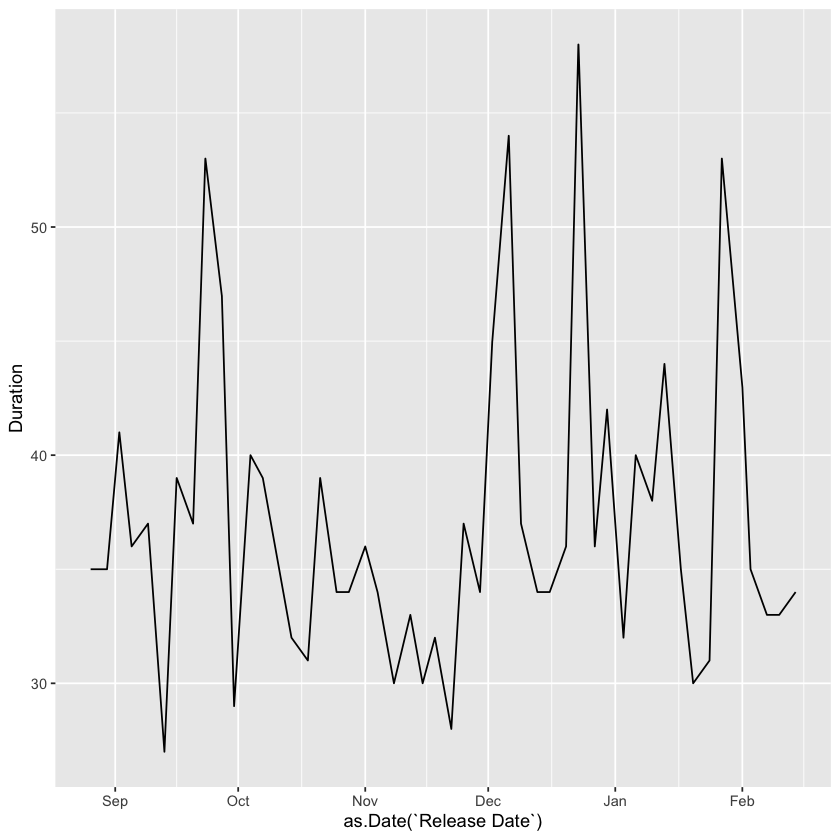

In [29]:
ggplot(response,aes(as.Date(`Release Date`),Duration)) + geom_line()